In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
import seaborn as sns
sns.set()

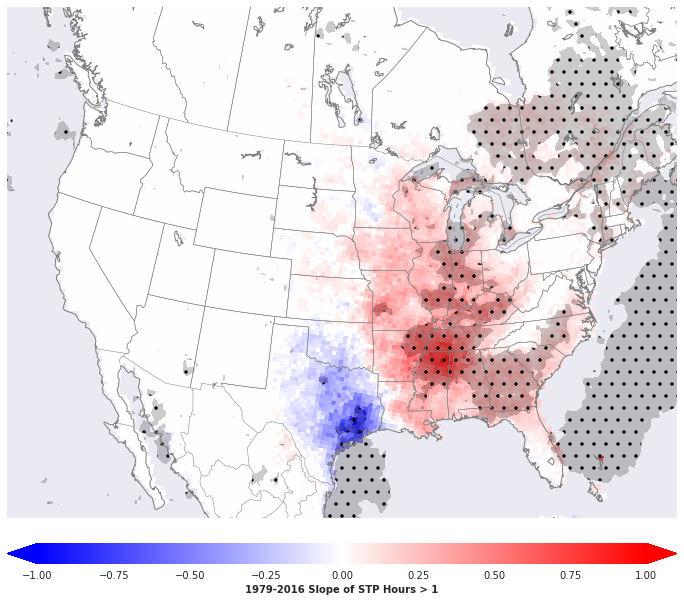

In [3]:
datadir = '/home/data/stp_narr/'
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()

#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/enso/shapefiles/US_outline.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip = path.contains_points(lonlat)

#reshape array
clip = clip.reshape(lats.shape)

stp_gt1_all=np.load('/home/data/stp_narr/stp_gt1_hours_all.npy')

vals=[]
var = np.sum(stp_gt1_all,axis=0)
# for row in np.arange(0,277,1):
#     for col in np.arange(0,349,1):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(years, var[:,row,col]*3.)
#         vals.append(slope)
# vals = np.array(vals)
# vals=vals.reshape(277,349)


def theilsen(a,years):
    yr,y,x = a.shape
    slope = np.zeros((y,x))   
    intercept = np.zeros((y,x))   
    lo = np.zeros((y,x))
    up = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
    return slope

def kendalltau(a,years):
    yr,y,x = a.shape   
    tau = np.zeros((y,x))   
    pval = np.zeros((y,x))   
    for yy in range(y):
        for xx in range(x):
            tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
    #return (tau,pval)
    return pval

slope = theilsen(var,np.arange(1979,2017,1))
pval = kendalltau(var,np.arange(1979,2017,1))

#print (pval.shape)

#print (vals.shape)
fig = plt.figure()
fig.set_size_inches(12,12)
m = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=20, urcrnrlat=55,llcrnrlon=-120,urcrnrlon=-60,resolution='l',area_thresh=1000)
m.drawcoastlines(color='gray')
m.drawstates(color='gray')
masked = maskoceans(lons,lats,slope)
m.drawcountries(color='gray')
x,y = m(lons,lats)
#plot = m.pcolormesh(x,y,masked,zorder=1, norm=colors.LogNorm(vmin=1, vmax=50),cmap=cm.magma)
plot = m.pcolormesh(x,y,masked,zorder=1,vmin=-1, vmax=1,cmap=cm.bwr)
colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
colbar.set_label('1979-2016 Slope of STP Hours > 1',fontsize='medium',weight='bold')
levs = [0,0.05]
m.contourf(x,y,pval,levs,cmap=None,colors='black',alpha=.2,hatches=['.'])
#levs1 = [-900,-1.96]
#m.contourf(x,y,sigdiff,levs1,color=None,hatch=['/'])
plt.show()
